In [7]:
# As usual, a bit of setup
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.misc import imread
from scipy.misc import imresize
from PIL import Image
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def load_Pandora18K(data_dir = '../dataset/Pandora_18k_flat_and_resized'):
    
    i = 0
    X_data = []
    Y_data = []
    
    for root, dirs, files in os.walk(data_dir):
        path = root.split(os.sep)
        for file in files:
            if '.jpg' in str(file).lower(): # an image file
                file_path = os.path.join(root,file)

                # Get image
                imagedata = imread(file_path)
                assert imagedata.shape == (500, 500, 3)
                X_data.append(imagedata)
                
                # Get class
                correct_class = -1
                if "01_Byzantin_Iconography" in root:
                    correct_class = 1
                elif "02_Early_Renaissance" in root:
                    correct_class = 2
                elif "03_Northern_Renaissance" in root:
                    correct_class = 3
                elif "04_High_Renaissance" in root:
                    correct_class = 4
                elif "05_Baroque" in root:
                    correct_class = 5
                elif "06_Rococo" in root:
                    correct_class = 6
                elif "07_Romanticism" in root:
                    correct_class = 7
                elif "08_Realism" in root:
                    correct_class = 8
                elif "09_Impressionism" in root:
                    correct_class = 9
                elif "10_Post_Impressionism" in root:
                    correct_class = 10
                elif "11_Expressionism" in root:
                    correct_class = 11
                elif "12_Symbolism" in root:
                    correct_class = 12
                elif "13_Fauvism" in root:
                    correct_class = 13
                elif "14_Cubism" in root:
                    correct_class = 14
                elif "15_Surrealism" in root:
                    correct_class = 15
                elif "16_AbstractArt" in root:
                    correct_class = 16
                elif "17_NaiveArt" in root:
                    correct_class = 17
                elif "18_PopArt" in root:
                    correct_class = 18
                
                assert correct_class != -1
                Y_data.append(correct_class)
                
                """
                i = i + 1

                if i >= 30: #this should be all of them, do the shuffling and subsampling below
                    X_data_arr = np.array(X_data)
                    Y_data_arr = np.array(Y_data)
                    return X_data_arr, Y_data_arr
                """
    X_data_arr = np.array(X_data)
    Y_data_arr = np.array(Y_data)
    return X_data_arr, Y_data_arr


In [9]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

data_dir = '../dataset/Pandora_18k_flat_and_resized'
#17876 images total

#grab data
print("Loading Pandora18k data...")
X_data, Y_data = load_Pandora18K(data_dir)

#shuffle x and y data together
print("Shuffling Pandora18k data...")
X_data, Y_data = unison_shuffled_copies(X_data, Y_data)

print(Y_data[0:10])

print("X_data.shape")
print(X_data.shape)
print("Y_data.shape")
print(Y_data.shape)

Loading Pandora18k data...
Shuffling Pandora18k data...
[ 8  5  9 16  5  6  8 18 15  9]
X_data.shape
(17876, 500, 500, 3)
Y_data.shape
(17876,)


In [10]:
#def get_data(num_training=8000, num_validation=1876, num_test=8000): 
def sub_sample_data(num_training=500, num_validation=500, num_test=500): #test with 300 images total
    
    #training data subsample
    print("Subsampling training...")
    mask = range(0, num_training)
    X_train = X_data[mask]
    y_train = Y_data[mask]
    
    #validation data subsample
    print("Subsampling validation...")
    mask = range(num_training, num_training + num_validation)
    X_val = X_data[mask]
    y_val = Y_data[mask]
    
    #test data subsample
    print("Subsampling test...")
    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    X_test = X_data[mask]
    y_test = Y_data[mask]
    
    """
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    """

    return X_train, y_train, X_val, y_val, X_test, y_test

# Invoke the above function to get our data.
print("calling get_data()...")
X_train, y_train, X_val, y_val, X_test, y_test = sub_sample_data()

X_train = X_train.astype(float)
X_val = X_val.astype(float)
X_test = X_test.astype(float)

print("X_train data type")
print(X_train.dtype)
print("X_val data type")
print(X_val.dtype)
print("X_test data type")
print(X_test.dtype)

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

calling get_data()...
Subsampling training...
Subsampling validation...
Subsampling test...
X_train data type
float64
X_val data type
float64
X_test data type
float64
Train data shape:  (500, 500, 500, 3)
Train labels shape:  (500,)
Validation data shape:  (500, 500, 500, 3)
Validation labels shape:  (500,)
Test data shape:  (500, 500, 500, 3)
Test labels shape:  (500,)


In [38]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 500, 500, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def style_model(img, y):
    """Generate class scores for img
    
    Inputs:
    - img: Tensor of image [batch_size, 500, 500, 3]
    - y: class [batch_size, 18]
    
    Returns:
    Class scores [batch_size, 18].
    """
    
    dims = tf.shape(img)
    batch_size = dims[0]
    
    conv1 = tf.layers.conv2d(
        inputs=img,
        filters=4,
        kernel_size=[10, 10],
        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32),
        bias_initializer=tf.zeros_initializer(),
        strides = [10,10],
        padding="valid",
        activation=tf.nn.relu)
    
    tf.verify_tensor_all_finite(conv1, "conv1 not ok", name=None)
    
    conv2 = tf.layers.conv2d(
        inputs=conv1,
        filters=4,
        kernel_size=[10, 10],
        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32),
        bias_initializer=tf.zeros_initializer(),
        strides = [10,10],
        padding="valid",
        activation=tf.nn.relu)
    
    print("conv2")
    print(conv2)
    
    tf.verify_tensor_all_finite(conv2, "conv2 not ok", name=None)
    
    flat = tf.reshape(conv2, [batch_size, 100]) #5 * 5 * 4
    
    tf.verify_tensor_all_finite(flat, "flat not ok", name=None)
    
    dense = tf.layers.dense(
        inputs=flat, 
        units=18,
        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32),
        bias_initializer=tf.zeros_initializer())

    tf.verify_tensor_all_finite(dense, "dense not ok", name=None)  
    
    return dense

y_out = style_model(X, y)

print("\nlabels shape")
print(y)
print("\nlogits shape")
print(y_out)

# define our loss
temp = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_out)
#total_loss_array = temp
total_loss_array = tf.clip_by_value(temp, 0, 1000)
print("\nprinting total_loss_array")
print(total_loss_array)
tf.verify_tensor_all_finite(total_loss_array, "total_loss_array not ok", name=None)


mean_loss = tf.clip_by_value(tf.reduce_mean(total_loss_array), -1e-10, 1e10)
print("\nprinting mean_loss")
print(mean_loss)
tf.verify_tensor_all_finite(mean_loss, "mean_loss not ok", name=None)

# define our optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1e-40,#5e-28,
    beta1=0.9,
    beta2=0.999,
    epsilon=1,#1e-07,
    use_locking=False,
    name='Adam')
#optimizer = tf.train.AdamOptimizer(5e-18) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)


#g_step = tf.Variable(0, trainable=False)
#learning_rate = 5e-18#tf.train.exponential_decay(5e-18, g_step,int(40000)/2, self.config.flag.step_decay_rate, staircase=True)
#optimizer = tf.train.AdamOptimizer(5e-18)
#tuples = optimizer.compute_gradients(mean_loss)
#grads = [entry[0] for entry in tuples]
#vars = [entry[1] for entry in tuples]
#outGrad = tf.global_norm(grads)        # FOR DEBUGGING
#grads, _ = tf.clip_by_global_norm(grads, 10)
#clipped_gradients = zip(grads, vars)
#learning_rate = learning_rate          # FOR DEBUGGING
#train_step = optimizer.apply_gradients(clipped_gradients, global_step=g_step)

conv2
Tensor("conv2d_2/Relu:0", shape=(?, 5, 5, 4), dtype=float32)

labels shape
Tensor("Placeholder_1:0", shape=(?,), dtype=int64)

logits shape
Tensor("dense/BiasAdd:0", shape=(?, 18), dtype=float32)

printing total_loss_array
Tensor("clip_by_value:0", shape=(?,), dtype=float32)

printing mean_loss
Tensor("clip_by_value_1:0", shape=(), dtype=float32)


Training


t_loss
(100,)
[  1.92498760e+01   7.06151581e+01   2.68080101e+01   4.69657135e+01
   3.07054043e+01   2.05714512e+01   6.85503540e+01   5.50633698e+01
   1.37040787e+01   4.93086243e+00   7.08369446e+01   5.64337730e+01
   7.09975662e+01   7.71626816e+01   3.68283195e+01   1.04930458e+02
   7.72435608e+01   5.07127075e+01   1.87121830e+01   5.79791565e+01
   3.92964058e+01   3.18094158e+01   3.22057190e+01   5.10487518e+01
   1.20866556e+01   3.08193398e+01   4.92256403e+00   3.03979068e-05
   3.20818634e+01   1.01524986e+02   2.35551739e+01   1.99687672e+00
   9.97556782e+00   1.19209282e-07   7.84195280e+00   5.56348963e-03
   8.25136948e+01   6.07739220e+01   1.18566427e+01   6.67801437e+01
   3.98052483e+01   6.88585663e+01   6.90593719e-02   1.00000000e+03
   8.34774399e+01   3.28486023e+01   3.58712158e+01   5.02100372e+01
   1.66773815e+01   1.00000000e+03   1.36554127e+01   1.49006348e+01
   1.82581064e-03   4.50665436e+01   1.04851074e+02   1.00000000e+03
   2.3157

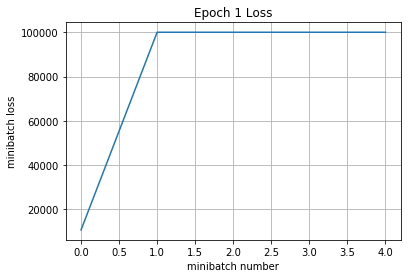

In [39]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs, batch_size, print_every=1,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = True#training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,total_loss_array,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            
            # generate indicies for the batch
            start_idx = (i*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]

            print("\n")
            if (np.isnan(Xd).any()):
                print("error, there is NAN in Xd")
            if (np.isnan(yd).any()):
                print("error, there is NAN in yd")
            

            """
            print("Xd")
            print(Xd.shape)
            print(Xd.dtype)
            
            print("X")
            print(Xd[idx,:].shape)
            
            print("y")
            print(yd[idx])
            print(yd.dtype)
            """
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, t_loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            print("t_loss")
            print(t_loss.shape)
            print(t_loss)
            
            
            print("corr")
            print(corr)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
            
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

my_batch_size = 100
train_num_epochs = 1


with tf.Session() as sess:
    with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,train_num_epochs,my_batch_size,1,train_step,True)
        """
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,my_batch_size)
        print('Test')
        run_model(sess,y_out,mean_loss,X_test,y_test,1,my_batch_size)
        """